In [51]:
# pip3 install -r requirements.txt

import freetype
from PIL import Image, ImageDraw
from io import StringIO
import os

In [ ]:
# Preset: 16x15
face = freetype.Face('SourceHanSansSC-VF.otf')
face.set_pixel_sizes(17,15)
face.set_var_design_coords((300,))

FB_W = 16
FB_H = 15
FB_W_HALF = FB_W // 2
OUT_FILE_NAME = 'font16x15.4FN'


In [34]:
# Preset: 12x12
face = freetype.Face('SourceHanSansSC-VF.otf')
face.set_pixel_sizes(12,12)
face.set_var_design_coords((300,))

FB_W = 12
FB_H = 12
FB_W_HALF = FB_W // 2
OUT_FILE_NAME = 'font12x12.4FN'

In [ ]:
# WQY_12X12
face = freetype.Face('wqy-microhei.ttc')
face.set_pixel_sizes(13,12)
# face.set_var_design_coords((320,))

FB_W = 12
FB_H = 11
FB_W_HALF = FB_W // 2
OUT_FILE_NAME = 'font12x11.wqy.4FN'

In [ ]:
# WQY_16X15
face = freetype.Face('wqy-microhei.ttc')
face.set_pixel_sizes(17,15)
face.set_var_design_coords((300,))

FB_W = 16
FB_H = 15
FB_W_HALF = FB_W // 2
OUT_FILE_NAME = 'font16x15.wqy.4FN'

In [51]:
# fusion
face = freetype.Face('fusion-pixel-monospaced.ttf')
face.set_pixel_sizes(12,12)
# face.set_var_design_coords((400,))

FB_W = 12
FB_H = 12
FB_W_HALF = FB_W // 2
OUT_FILE_NAME = 'fusion-12px.4FN'

In [46]:
# hzk
face = freetype.Face('hzk-pixel-12px.ttf')
face.set_pixel_sizes(12,12)
# face.set_var_design_coords((400,))

FB_W = 12
FB_H = 12
FB_W_HALF = FB_W // 2
OUT_FILE_NAME = 'hzk-12px.4FN'

In [58]:
# 微软雅黑
face = freetype.Face('MSYHL.TTC')
face.set_pixel_sizes(14,14)
# face.set_var_design_coords((400,))

FB_W = 14
FB_H = 14
FB_W_HALF = FB_W // 2
OUT_FILE_NAME = 'msyh-12px.4FN'

In [116]:

face = freetype.Face('zpix.ttf')
face.set_pixel_sizes(12,12)
# face.set_var_design_coords((400,))

FB_W = 11
FB_H = 11
FB_W_HALF = FB_W // 2
OUT_FILE_NAME = 'zpix.4FN'

In [117]:
# Define functions to draw the character

HEADER_SIZE = 1
BMP_ROW_SIZE = (FB_W - 1) // 8 + 1
BMP_SIZE = BMP_ROW_SIZE * FB_H
CHAR_DATA_SIZE = BMP_SIZE + HEADER_SIZE
FONT_PAGE_SIZE = CHAR_DATA_SIZE * 256

print('BMP_SIZE', BMP_SIZE)
logData = StringIO()
def log(str):
    global logData
    logData.write(str + '\n')


def checkWidthEnforcement(ch):
    if (ch == ' '):
        return FB_W_HALF
    return 0

def renderChar(ch):
    face.load_char(ch, flags=freetype.FT_LOAD_TARGET_MONO | freetype.FT_LOAD_RENDER)
    fb = [0] * (FB_W*FB_H)
    g = face.glyph
    offY = FB_H - max(g.bitmap_top, 0) - 1
    offX = max(g.bitmap_left, 0)
    b = g.bitmap
    w = b.width
    totalWidth = offX + w
    fbWidth = min(FB_W, totalWidth)
    if fbWidth <= 0:
        fbWidth = 1
    fbWidth = max(fbWidth, checkWidthEnforcement(ch))
    h = b.rows
    offY = min(offY, FB_H - h)
    pitch = b.pitch
    buf = b.buffer
    t = 0
    overflowCnt = 0
    for cy in range(0, h):
        for cx in range(0, w):
            if (cx % 8 == 0):
                t = buf[pitch * cy + cx // 8]
            v = 0
            if (t & 0x80):
                v = 1
            posX = offX + cx
            posY = offY + cy
            if (posX < 0) or (posX >= FB_W) or (posY < 0) or (posY >= FB_H):
                overflowCnt += 1
                if overflowCnt <= 2:
                    log('overflow %d %d %s' % ( posX, posY, ch))
            else:
                fb[posX + posY * FB_W] = v
            t <<= 1
    return (fb, fbWidth)

def printFB(fb, fbWidth):
    ret = ''
    for y in range(0, FB_H):
        for x in range(0, fbWidth):
            ret += ['.', '#'][fb[x + y * FB_W]]
        ret += '\n'
    print(ret)
    print(fbWidth)

# Generate 4FN binary font file

logData = StringIO()
fontMagic = b'44Font0000000' + bytes([FB_W, FB_H, BMP_SIZE])
fontIndex = [0xFF] * 256
fontBuf = b''
fontBufPtr = 0

totCnt = 0
# [(0x4E, 0x9F)]是中文的
PLANES = [(0x4E, 0x9F)] #[(0, 0), (0x30, 0x30), ]
for (l, r) in PLANES:
    for p in range(l, l + r + 1):
        validCharCount = 0
        pageBuf = b''
        for rune in range(p << 8, (p << 8) + 256):
            header = 0
            bmp = [0] * (BMP_SIZE)
            if face.get_char_index(rune) != 0:
                validCharCount += 1
                totCnt += 1
                log(chr(rune))
            (fb, fbWidth) = renderChar(chr(rune))
            header = fbWidth
            for y in range(0, FB_H):
                for x in range(0, FB_W):
                    if fb[y * FB_W + x]:
                        bmp[BMP_ROW_SIZE * y + (x // 8)] |= 1 << (x % 8)
            pageBuf += bytes([header])
            pageBuf += bytes(bmp)
        log('0x%02x00 %d %d' % (p, validCharCount, len(pageBuf)))
        if validCharCount == 0:
            continue
        fontIndex[p] = fontBufPtr
        fontBuf += pageBuf
        fontBufPtr += 1

with open(OUT_FILE_NAME, 'wb') as f:
    f.write(fontMagic)
    f.write(bytes(fontIndex))
    f.write(fontBuf)

with open('log.txt', 'wb') as f:
    f.write(logData.getvalue().encode('utf-8', 'ignore'))

print(totCnt)

BMP_SIZE 22
20902


In [118]:
# Print a character to console

fb, fbWidth = renderChar('宇')

printFB(fb, fbWidth)

.....#.....
###########
#.........#
#.........#
.#########.
.....#.....
.....#.....
###########
.....#.....
.....#.....
...###.....

11


471.765625


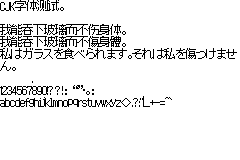

In [119]:
# Draw a PNG test image

txt = """CJK字体测试。

我能吞下玻璃而不伤身体。
我能吞下玻璃而不傷身體。 
私はガラスを食べられます。それは私を傷つけません。
나는 유리를 먹을 수 있어요. 그래도 아프지 않아요
1234567890!?？！：“”·。：
abcdefghijklmnopqrstuvwxyz<>.?:"|_+-=~`
"""
IMAGE_WIDTH = 240
IMAGE_HIGHT = 160
img = Image.new('RGB', (IMAGE_WIDTH,IMAGE_HIGHT), color='white')
pixels = img.load()
posX = 0
posY = 0

def drawFB(fb, fbWidth):
    global posX, posY

    if (posX + fbWidth >= IMAGE_WIDTH):
        posX = 0
        posY += FB_H + 1
    for y in range(0, FB_H):
        for x in range(0, fbWidth):
            if fb[x + y * FB_W]:
                pixels[posX + x, posY + y] = (0,0,0)
    posX += fbWidth



for ch in txt:
    if (ch == '\n'):
        posX = 0
        posY += FB_H + 1
        continue
    fb, fbWidth = renderChar(ch)
    drawFB(fb, fbWidth)
print(os.stat(OUT_FILE_NAME).st_size/1024)
img

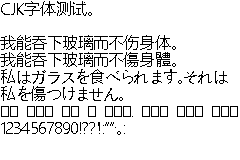

In [35]:

img

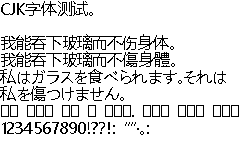

In [41]:
img